# LiDAR vs Insitu Tree Height Comparison

This notebook compares tree height measurements for two NEON sites: the SJER and SOAP sites.

In [14]:
import os
import pathlib

import earthpy as et
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterstats as rs
import xarray as xr
import rioxarray as rxr
import seaborn as sns

et.data.get_data('spatial-vector-lidar')

home_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'spatial-vector-lidar'
)

os.chdir(home_dir)

In [15]:
# Define paths to data

# SJER site
sjer_base_dir = os.path.join(
    'california',
    'neon-sjer-site'
)

sjer_insitu_path = os.path.join(
    sjer_base_dir,
    '2013',
    'insitu',
    'veg_structure',
    'D17_2013_SJER_vegStr.csv'
)

sjer_plots_path = os.path.join(
    sjer_base_dir,
    'vector_data',
    'SJER_plot_centroids.shp'
)

sjer_chm_path = os.path.join(
    sjer_base_dir,
    '2013',
    'lidar',
    'SJER_lidarCHM.tif'
)

sjer_plots_path = os.path.join(
    sjer_base_dir,
    'vector_data',
    'SJER_plot_centroids.shp'
)

# Soap site
soap_base_dir = os.path.join(
    'california',
    'neon-soap-site'
)

soap_insitu_path = os.path.join(
    soap_base_dir,
    '2013',
    'insitu',
    'veg-structure',
    'D17_2013_SOAP_vegStr.csv'
)

soap_plots_path = os.path.join(
    soap_base_dir,
    'vector_data',
    'SOAP_centroids.shp'
)

soap_chm_path = os.path.join(
    soap_base_dir,
    '2013',
    'lidar',
    'SOAP_lidarCHM.tif'
)

soap_plots_path = os.path.join(
    soap_base_dir,
    'vector_data',
    'SOAP_centroids.shp'
)

In [16]:
def _calc_lidar_chm_stats(plots_path, chm_path, 
                            prepend_string=None, prepend_col=None):
    """
    Caculate LiDAR max and mean tree height for plots

    Parameters
    ----------
    plots_path: str
      File path to plot locations (point locations)
    chm_path: str
      File path to LiDAR file
    prepend_string: str
      String to prepend to ID (optional)
    prepend_col: str
      Column name to prepend to

    Returns
    -------
    GeoDataFrame
      Plot data with LiDAR statistics appended
    """
    # Read in plot centroids
    plots_gdf = gpd.read_file(plots_path)

    # Buffer points to get plot boundaries
    plots_gdf.geometry = plots_gdf.geometry.buffer(20)

    # Calculate zonal stats for each plot
    chm_stats = rs.zonal_stats(
        plots_gdf, chm_path,
        stats=['mean', 'max'],
        geojson_out = True, nodata=0
    )
    chm_stat_gdf = gpd.GeoDataFrame.from_features(chm_stats)
    chm_stat_gdf = chm_stat_gdf.rename(
        columns={'max': 'lidar_max', 'mean': 'lidar_mean'})
    
    if prepend_string:
        chm_stat_gdf[prepend_col] = prepend_string + chm_stat_gdf['ID']
    
    return chm_stat_gdf

In [17]:
def _calc_insitu_height_stats(insitu_path):
    """
    Caculate insitu max and mean tree height

    Parameters
    ----------
    insitu_path: str
      File path to insitu data

    Returns
    -------
    GeoDataFrame
      Plot data with stats by plot id
    """ 
    insitu_df = (
        pd.read_csv(insitu_path)
        .groupby('plotid')['stemheight']
        .agg(['max', 'mean'])
        .rename(columns={'max': 'insitu_max', 'mean': 'insitu_mean'})
    )
    df = gpd.GeoDataFrame(insitu_df)

    return df

In [18]:
def calc_height_stats(plots_path, chm_path, insitu_path, 
                      id_col="Plot_ID", prepend_string=None):
  """
  Merge insitu and LiDAR data

  Parameters
  ----------
  plots_path: str
    File path to plot locations (point locations)
  chm_path: str
    File path to LiDAR file
  insitu_path: str
    File path to insitu data
  id_col: str
    Column name to join data on

  Returns
  -------
  GeoDataFrame
    Merged LiDAR and insitu data
  """
  
  chm_stats_gdf = _calc_lidar_chm_stats(plots_path, chm_path, 
                                        prepend_string=prepend_string,
                                        prepend_col=id_col)
  # Load and merge insitu data
  insitu_height_df = _calc_insitu_height_stats(insitu_path)
  
  stat_df = (
      chm_stats_gdf
      .merge(insitu_height_df, left_on=id_col, right_index=True)
  )
  return stat_df


In [19]:
def plot_comparison(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.scatter(
        df['lidar_mean'], df['insitu_mean']
    )
    ax1.set(xlim=(0, 30), ylim=(0, 30), aspect='equal')
    ax1.set_title('Mean')
    sns.regplot(x='lidar_mean', y='insitu_mean', 
                data=df,
                color='purple',
                ax=ax1)
    ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--', c='k')
    ax2.scatter(df['lidar_max'], df['insitu_max'])
    ax2.set(xlim=(0, 30), ylim=(0, 30), aspect='equal')
    ax2.set_title('Maximum')
    sns.regplot(x='lidar_max', y='insitu_max', 
                data=df,
                color='purple',
                ax=ax2)
    ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--', c='k')
    plt.suptitle('Comparison of LiDAR and insitu height measurements at the \n'
                'NEON San Joaquin Experimental Range (SJER) field site')
    plt.tight_layout()

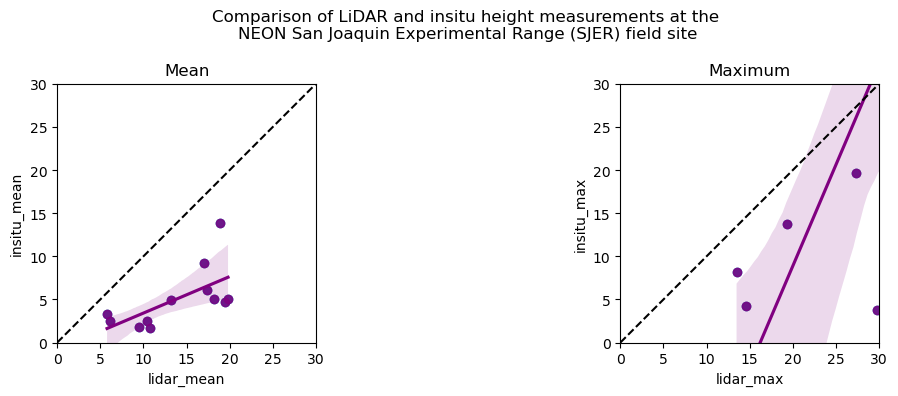

In [20]:
# Calculate and plot SOAP site
soap_df = calc_height_stats(soap_plots_path, soap_chm_path, soap_insitu_path,
                  id_col="ID", prepend_string="SOAP")
plot_comparison(soap_df)

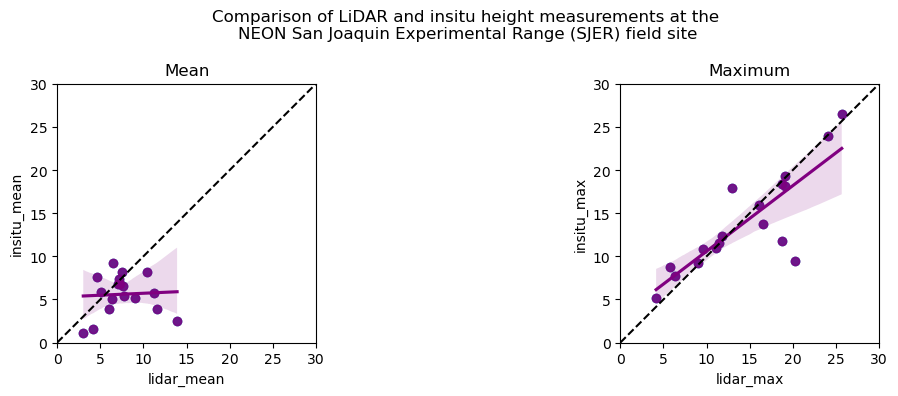

In [21]:
# Calculate and plot SJER site
sjer_df = calc_height_stats(sjer_plots_path, sjer_chm_path, sjer_insitu_path)
plot_comparison(sjer_df)